In [2]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing, pipeline
import torch
from torch import nn, optim, utils

In [3]:
def clip_gradients_(
    clip_grad_strategy,
    model_fn,
    clip_value=None,
    error_if_nonfinite=False,
    max_norm=None,
    norm_type=2.0):
    if clip_grad_strategy == "value" and clip_value is not None:
        nn.utils.clip_grad_value_(
            model_fn.parameters(),
            clip_value
        )
    elif clip_grad_strategy == "norm" and max_norm is not None:
        nn.utils.clip_grad_norm_(
            model_fn.parameters(),
            max_norm,
            norm_type,
            error_if_nonfinite
        )
    elif clip_grad_strategy is None:
        pass
    else:
        raise NotImplementedError()


def compute_average_loss(dataloader, loss_fn, model_fn):
    total_loss = torch.zeros(1, 1)
    for features, targets in dataloader:
        predictions = model_fn(features)        
        total_loss += loss_fn(predictions, targets)
    average_loss = total_loss / len(dataloader)
    return average_loss


def initialize_linear_layer(
    in_features,
    out_features,
    init_strategy_=nn.init.kaiming_uniform_):
    linear_layer = nn.Linear(in_features, out_features)
    init_strategy_(linear_layer.weight)
    return linear_layer


def make_mlp_classifier(
    input_size,
    hidden_sizes=None,
    output_size=2,
    activation_fn=None,
    init_strategy_=nn.init.kaiming_uniform_,
    batch_normalization=False):
    modules = []
    hidden_sizes = [] if hidden_sizes is None else hidden_sizes
    for hidden_size in hidden_sizes:
        hidden_layer = initialize_linear_layer(
            input_size,
            hidden_size,
            init_strategy_,
        )
        modules.append(hidden_layer)
        if batch_normalization:
            modules.append(nn.BatchNorm1d(hidden_size))
        if activation_fn is not None:
            modules.append(activation_fn)
        input_size=hidden_size
    output_layer = initialize_linear_layer(
            input_size,
            output_size,
            init_strategy_,
    )
    modules.append(output_layer)
    modules.append(nn.LogSoftmax(dim=1))
    model_fn = nn.Sequential(*modules)
    return model_fn, nn.NLLLoss()


## Define the training loop

In [4]:
def fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    clip_grad_strategy=None,
    clip_value=None,
    error_if_nonfinite=False,
    lr_scheduler=None,
    log_epochs=1,
    max_epochs=1,
    max_norm=None,
    norm_type=2.0):
  
    history = {
        "epoch": [],
        "average_train_loss": [],
        "average_val_loss": []
    }

    for epoch in range(max_epochs):
        total_train_loss = torch.zeros(1, 1)
        model_fn = model_fn.train()
        for features, targets in train_dataloader:
            
            # forward pass
            predictions = model_fn(features)        
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

            # backward pass
            loss.backward()
            clip_gradients_(
                clip_grad_strategy,
                model_fn,
                clip_value,
                error_if_nonfinite,
                max_norm,
                norm_type
            )
            optimizer.step()        
            optimizer.zero_grad()
        
        average_train_loss = total_train_loss / len(train_dataloader)
        history["epoch"].append(epoch)
        history["average_train_loss"].append(average_train_loss.item())

        # validation after every training epoch
        model_fn = model_fn.eval()
        with torch.inference_mode():
            average_val_loss = compute_average_loss(
                val_dataloader,
                loss_fn,
                model_fn
            )
        history["average_val_loss"].append(average_val_loss.item())

        # update the learning rate after every training epoch
        if lr_scheduler is not None:
            lr_scheduler.step()

        if epoch % log_epochs == 0:
            message = f"Epoch {epoch}, Average train Loss {average_train_loss.item():.4f}, Average val Loss {average_val_loss.item():.4f}"
            print(message)

    history_df = (pd.DataFrame.from_dict(history)
                              .set_index("epoch"))
    return history_df


## Load the data

In [5]:
INPUT_SIZE = 784
OUTPUT_SIZE = 10

_train_data = pd.read_csv(
    "./sample_data/mnist_train_small.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)
train_data, val_data = model_selection.train_test_split(
    _train_data,
    test_size=0.1,
    stratify=_train_data.loc[:, "label"]
)

test_data = pd.read_csv(
    "./sample_data/mnist_test.csv",
    header=None,
    names=["label"] + [f"p{i}" for i in range(INPUT_SIZE)],
)


In [6]:
features_preprocessor = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    preprocessing.FunctionTransformer(lambda arr: arr.astype(np.float32)),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)

target_preprocessor = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(lambda df: df.to_numpy()),
    preprocessing.FunctionTransformer(lambda arr: torch.from_numpy(arr))
)


In [7]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# create the training dataset and dataloader
train_features_tensor = features_preprocessor.fit_transform(
    train_data.drop("label", axis=1)
)

train_target_tensor = target_preprocessor.fit_transform(
    train_data.loc[:, "label"]
)

train_dataset = utils.data.TensorDataset(
    train_features_tensor,
    train_target_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the validation dataset and dataloader
val_features_tensor = features_preprocessor.transform(
    val_data.drop("label", axis=1)
)

val_target_tensor = target_preprocessor.transform(
    val_data.loc[:, "label"]
)

val_dataset = utils.data.TensorDataset(
    val_features_tensor,
    val_target_tensor
)

val_dataloader = utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# create the test dataset and dataloader
test_features_tensor = features_preprocessor.transform(
    test_data.drop("label", axis=1)
)

test_target_tensor = target_preprocessor.transform(
    test_data.loc[:, "label"]
)

test_dataset = utils.data.TensorDataset(
    test_features_tensor,
    test_target_tensor
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)


# Learning Rate Schedulers

In [ ]:
optim.lr_scheduler.

## Power Scheduling

In [ ]:
optim.lr_scheduler.PolynomialLR?

Epoch 0, Average train Loss 0.4583, Average val Loss 0.4889
Epoch 1, Average train Loss 0.2611, Average val Loss 0.3173
Epoch 2, Average train Loss 0.2032, Average val Loss 0.2381
Epoch 3, Average train Loss 0.1691, Average val Loss 0.2061
Epoch 4, Average train Loss 0.1481, Average val Loss 0.1899
Epoch 5, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 6, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 7, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 8, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 9, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 10, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 11, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 12, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 13, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 14, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 15, Average train Loss 0.1386, Average val Loss 0.1899
Epoch 16, Average train Loss 0.138

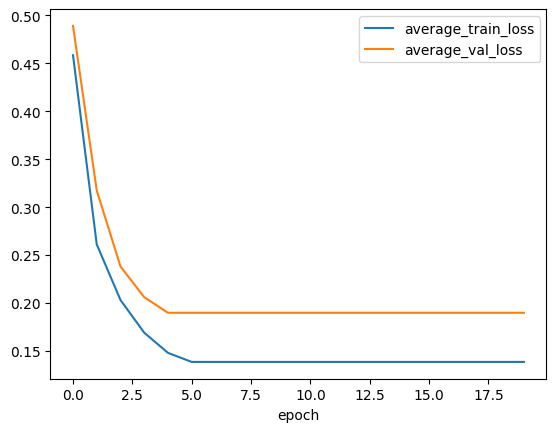

In [9]:
HIDDEN_SIZE = 100
LEARNING_RATE = 1e-1
MAX_EPOCHS = 20

model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.PolynomialLR(optimizer, power=1.0) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Exponential Scheduling

In [ ]:
optim.lr_scheduler.ExponentialLR?

Epoch 0, Average train Loss 0.4584, Average val Loss 0.5088
Epoch 1, Average train Loss 0.2583, Average val Loss 0.3131
Epoch 2, Average train Loss 0.1935, Average val Loss 0.2352
Epoch 3, Average train Loss 0.1558, Average val Loss 0.2121
Epoch 4, Average train Loss 0.1304, Average val Loss 0.1999
Epoch 5, Average train Loss 0.1119, Average val Loss 0.1915
Epoch 6, Average train Loss 0.0975, Average val Loss 0.1860
Epoch 7, Average train Loss 0.0864, Average val Loss 0.1810
Epoch 8, Average train Loss 0.0774, Average val Loss 0.1779
Epoch 9, Average train Loss 0.0702, Average val Loss 0.1756
Epoch 10, Average train Loss 0.0641, Average val Loss 0.1739
Epoch 11, Average train Loss 0.0590, Average val Loss 0.1727
Epoch 12, Average train Loss 0.0547, Average val Loss 0.1718
Epoch 13, Average train Loss 0.0510, Average val Loss 0.1711
Epoch 14, Average train Loss 0.0479, Average val Loss 0.1705
Epoch 15, Average train Loss 0.0452, Average val Loss 0.1700
Epoch 16, Average train Loss 0.042

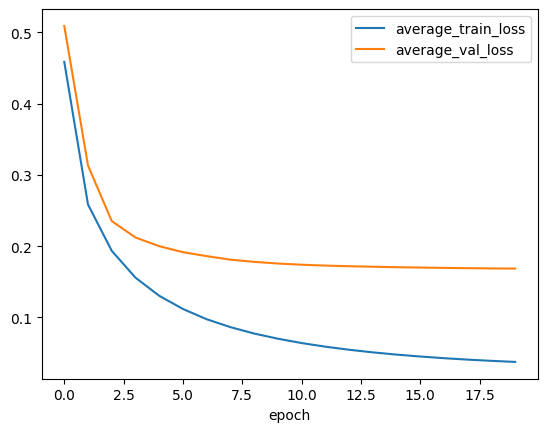

In [ ]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Step-wise Constant Scheduling

In [ ]:
optim.lr_scheduler.StepLR?

Epoch 0, Average train Loss 0.4657, Average val Loss 0.4110
Epoch 1, Average train Loss 0.2748, Average val Loss 0.3045
Epoch 2, Average train Loss 0.2088, Average val Loss 0.2220
Epoch 3, Average train Loss 0.1658, Average val Loss 0.2040
Epoch 4, Average train Loss 0.1362, Average val Loss 0.1908
Epoch 5, Average train Loss 0.0951, Average val Loss 0.1765
Epoch 6, Average train Loss 0.0898, Average val Loss 0.1746
Epoch 7, Average train Loss 0.0871, Average val Loss 0.1735
Epoch 8, Average train Loss 0.0848, Average val Loss 0.1726
Epoch 9, Average train Loss 0.0827, Average val Loss 0.1718
Epoch 10, Average train Loss 0.0795, Average val Loss 0.1720
Epoch 11, Average train Loss 0.0787, Average val Loss 0.1722
Epoch 12, Average train Loss 0.0784, Average val Loss 0.1722
Epoch 13, Average train Loss 0.0781, Average val Loss 0.1721
Epoch 14, Average train Loss 0.0779, Average val Loss 0.1720
Epoch 15, Average train Loss 0.0775, Average val Loss 0.1720
Epoch 16, Average train Loss 0.077

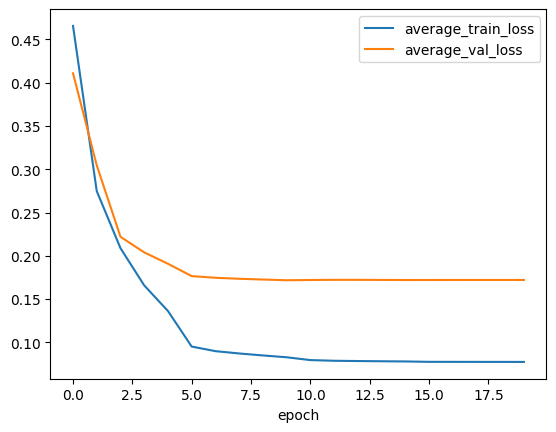

In [ ]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1,
) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## 1-cycle Scheduling

In [ ]:
optim.lr_scheduler.OneCycleLR?

Epoch 0, Average train Loss 0.4950, Average val Loss 0.2927
Epoch 1, Average train Loss 0.2714, Average val Loss 0.2415
Epoch 2, Average train Loss 0.2126, Average val Loss 0.2050
Epoch 3, Average train Loss 0.1723, Average val Loss 0.1861
Epoch 4, Average train Loss 0.1436, Average val Loss 0.1745
Epoch 5, Average train Loss 0.1217, Average val Loss 0.1617
Epoch 6, Average train Loss 0.1038, Average val Loss 0.1550
Epoch 7, Average train Loss 0.0895, Average val Loss 0.1508
Epoch 8, Average train Loss 0.0773, Average val Loss 0.1468
Epoch 9, Average train Loss 0.0667, Average val Loss 0.1403
Epoch 10, Average train Loss 0.0574, Average val Loss 0.1356
Epoch 11, Average train Loss 0.0495, Average val Loss 0.1328
Epoch 12, Average train Loss 0.0430, Average val Loss 0.1311
Epoch 13, Average train Loss 0.0377, Average val Loss 0.1307
Epoch 14, Average train Loss 0.0341, Average val Loss 0.1303
Epoch 15, Average train Loss 0.0309, Average val Loss 0.1313
Epoch 16, Average train Loss 0.028

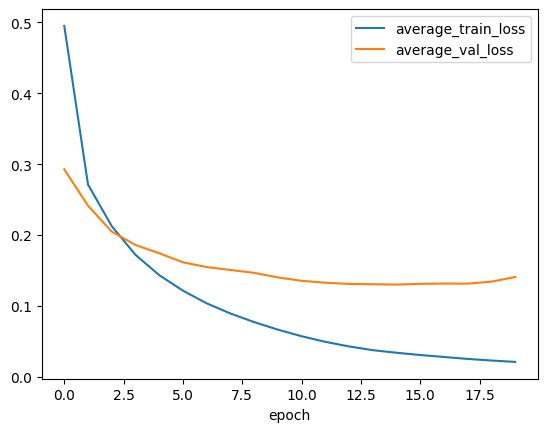

In [10]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE / 10)
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    epochs=MAX_EPOCHS,
    steps_per_epoch=len(train_dataloader),
    max_lr=LEARNING_RATE,
) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Performance Scheduling

In [ ]:
optim.lr_scheduler.ReduceLROnPlateau?

In [11]:
def fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    clip_grad_strategy=None,
    clip_value=None,
    error_if_nonfinite=False,
    lr_scheduler=None,
    log_epochs=1,
    max_epochs=1,
    max_norm=None,
    norm_type=2.0):
  
    history = {
        "epoch": [],
        "average_train_loss": [],
        "average_val_loss": []
    }

    for epoch in range(max_epochs):
        total_train_loss = torch.zeros(1, 1)
        model_fn = model_fn.train()
        for features, targets in train_dataloader:
            
            # forward pass
            predictions = model_fn(features)        
            loss = loss_fn(predictions, targets)
            total_train_loss += loss

            # backward pass
            loss.backward()
            clip_gradients_(
                clip_grad_strategy,
                model_fn,
                clip_value,
                error_if_nonfinite,
                max_norm,
                norm_type
            )
            optimizer.step()        
            optimizer.zero_grad()
        
        average_train_loss = total_train_loss / len(train_dataloader)
        history["epoch"].append(epoch)
        history["average_train_loss"].append(average_train_loss.item())

        # validation after every training epoch
        model_fn = model_fn.eval()
        with torch.inference_mode():
            average_val_loss = compute_average_loss(
                val_dataloader,
                loss_fn,
                model_fn
            )
        history["average_val_loss"].append(average_val_loss.item())

        # update the learning rate after every training epoch
        if lr_scheduler is not None:
            lr_scheduler.step(average_val_loss.item())

        if epoch % log_epochs == 0:
            message = f"Epoch {epoch}, Average train Loss {average_train_loss.item():.4f}, Average val Loss {average_val_loss.item():.4f}"
            print(message)

    history_df = (pd.DataFrame.from_dict(history)
                              .set_index("epoch"))
    return history_df


Epoch 0, Average train Loss 0.4606, Average val Loss 0.7319
Epoch 1, Average train Loss 0.2681, Average val Loss 0.3786
Epoch 2, Average train Loss 0.2002, Average val Loss 0.2855
Epoch 3, Average train Loss 0.1586, Average val Loss 0.2433
Epoch 4, Average train Loss 0.1294, Average val Loss 0.2146
Epoch 5, Average train Loss 0.1074, Average val Loss 0.1931
Epoch 6, Average train Loss 0.0902, Average val Loss 0.1768
Epoch 7, Average train Loss 0.0755, Average val Loss 0.1633
Epoch 8, Average train Loss 0.0634, Average val Loss 0.1565
Epoch 9, Average train Loss 0.0526, Average val Loss 0.1528
Epoch 10, Average train Loss 0.0434, Average val Loss 0.1519
Epoch 11, Average train Loss 0.0359, Average val Loss 0.1528
Epoch 12, Average train Loss 0.0294, Average val Loss 0.1544
Epoch 13, Average train Loss 0.0242, Average val Loss 0.1561
Epoch 14, Average train Loss 0.0198, Average val Loss 0.1585
Epoch 15, Average train Loss 0.0160, Average val Loss 0.1607
Epoch 16, Average train Loss 0.012

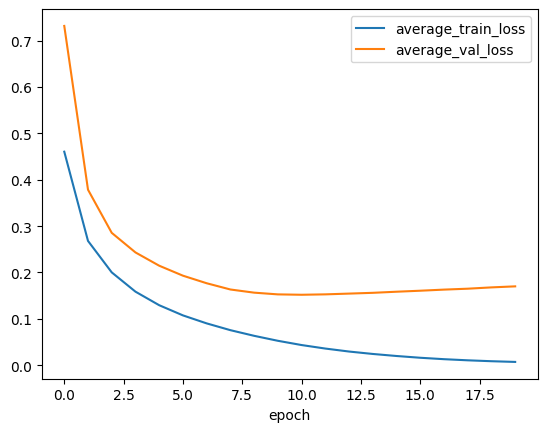

In [12]:
model_fn, loss_fn = make_mlp_classifier(
    input_size=INPUT_SIZE, 
    hidden_sizes=[HIDDEN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE], 
    output_size=OUTPUT_SIZE, 
    activation_fn=nn.SELU(),
    init_strategy_=nn.init.xavier_normal_
)

optimizer = optim.SGD(model_fn.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min"
) 

history = fit(
    loss_fn,
    model_fn,
    optimizer,
    train_dataloader,
    val_dataloader,
    lr_scheduler=lr_scheduler,
    max_epochs=MAX_EPOCHS
)

_ = history.plot()

## Exercise:

Create a MLP with three hidden layers, each with 100 neurons per layer, and train it for 10 epochs using the Adam optimizer with the following learning rate schedulers. 

1. ExponentialLR
2. ReduceLROnPlateau
3. OneCycleLR

Plot the learning rate schedule, as well as the training and validation loss curves. Compare and contrast.